In [1]:
import ROOT
import ostap.fixes.fixes
from ostap.core.core import cpp, Ostap
from ostap.core.core import pwd, cwd, ROOTCWD
from ostap.core.core import rootID, funcID, funID, fID, histoID, hID, dsID
from ostap.core.core import VE
from ostap.histos.histos import h1_axis, h2_axes, h3_axes
from ostap.histos.graphs import makeGraph, hToGraph, hToGraph2, hToGraph3, lw_graph
import ostap.trees.trees
import ostap.trees.cuts
import ostap.histos.param
import ostap.histos.compare
import ostap.io.root_file
import ostap.math.models
import ostap.fitting.roofit 
import ostap.fitting.models as Models

Welcome to JupyROOT 6.20/06


In [2]:
canv = ROOT.TCanvas("canv","canv",900,450)
rfile = ROOT.TFile("two/new.root","READ")
ds = rfile["tree"]

In [32]:
from math import sqrt
my_events = []
for ev in ds:
    lCSC  = sqrt( ev.xCSC**2 + ev.yCSC**2 )
    zTPC  = ev.zpos+2.19+ROOT.gRandom.Gaus(0,0.2576)
    Treco = ev.Tp+ROOT.gRandom.Gaus(0,0.05)
    evt = {"T":Treco, "l":lCSC, "Z":zTPC, "Atr":ev.THETAe, "Ttr":ev.Tp, "Ztr":ev.zpos}
    my_events.append( evt )
print("EVENTS SELECTED: " + str(len(my_events)))

EVENTS SELECTED: 250000


h1: mean=( 135.257 +- 0.00221494 )	 rms=( 0.428996 +- 0.00132606 )	0.003154640662116283
h2: mean=( 135.257 +- 0.00221494 )	 rms=( 0.428996 +- 0.00132606 )	( 1.63758e-05 +- 2.68168e-10 )
list mean  135.10510678010147 +- 0.000610557223230696
list sigma 0.1182543899737599


Warning in <TROOT::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h2 (Potential memory leak).


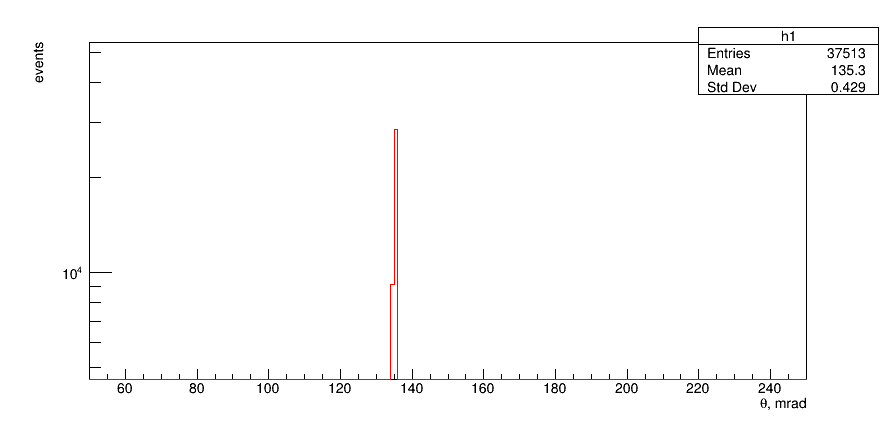

In [36]:
from statistics import mean, median, stdev
h1 = ROOT.TH1F("h1",";#theta, mrad;events",200,50,250)
h2 = ROOT.TH1F("h2",";#theta, mrad;events",200,50,250)
h2.SetLineColor(2)
evts = 0.
thetas = []
for ev in my_events:
    if ev["Ttr"]>4.985 and ev["Ttr"]<5.015:
        h1.Fill(1000.*ev["Atr"])
    if ev["Ttr"]>4.985 and ev["Ttr"]<5.015:
        h2.Fill(1000.*ev["Atr"])
        thetas.append( 1000.*ev["Atr"] )
        evts+=1.
h1.Draw()
h2.Draw("same")
ROOT.gPad.SetLogy()
canv.Draw()
print("h1: mean=" + str(h1.mean()) + "\t rms=" + str(h1.rms()) + "\t" + str(h1.rms().value()/sqrt(18493.)))
print("h2: mean=" + str(h2.mean()) + "\t rms=" + str(h2.rms()) + "\t" + str(h2.mean().prec()))
print("list mean  " + str(mean(thetas)) + " +- " + str(stdev(thetas)/sqrt(evts)))
print("list sigma " + str(stdev(thetas)) )

36517 events
TRUE mean( 135.105 +- 0.000618804 ) mrad.
REC. mean( 135.088 +- 0.0261901 ) mrad.	( 0.000193875 +- 3.75874e-08 )

****************************************
Minimizer is Linear / Migrad
Chi2                      =       37.956
NDf                       =           35
p0                        =     0.208745   +/-   0.0173615   
p1                        =     0.135916   +/-   2.66739e-05 


Warning in <TROOT::Append>: Replacing existing TH1: hR_Ztr (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hR (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hA (Potential memory leak).


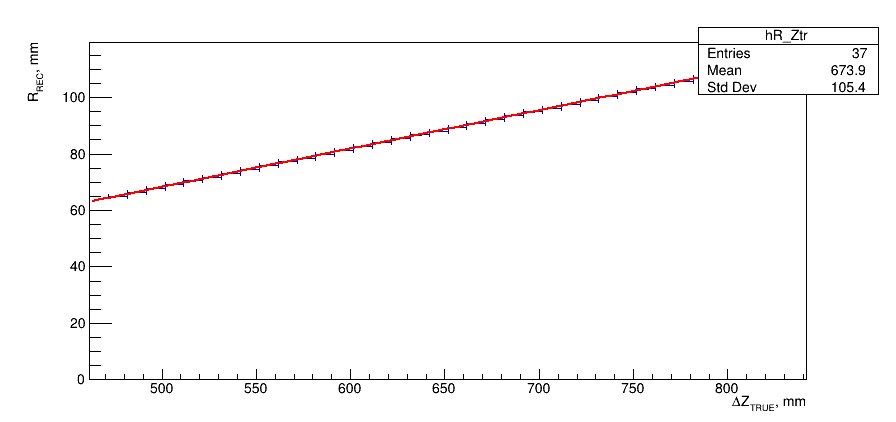

In [37]:
hR_Ztr = ROOT.TH1F("hR_Ztr",";#DeltaZ_{TRUE}, mm;R_{REC}, mm",38,851.6-390.0,851.6-10.0)
hR     = ROOT.TH1F("hR",";R_{REC},mm;events",30000,0,300)
hA     = ROOT.TH1F("hA",";#theta, mrad;events",200,100,300)
Nevt = 0
dT = 0.015
As = []
vR = []
vZ = []
eR = []
eZ = []
for bin in range(1,38):
    hR.Reset()
    evts = 0.
    Rs = []
    Zs = []
    for ev in my_events:
        if ev["Ttr"]>5.-dT and ev["Ttr"]<5.+dT:
            if ev["Ztr"]>10.*bin and ev["Ztr"]<10.*(bin+1):
                hR.Fill(ev["l"])
                hA.Fill(1000.*ev["Atr"])
                evts+=1.
                Zs.append(851.6-ev["Ztr"])
                Rs.append(ev["l"])
                As.append(1000.*ev["Atr"])
                Nevt+=1
    vR.append(mean(Rs))
    vZ.append(mean(Zs))
    eR.append(stdev(Rs)/sqrt(evts))
    eZ.append(stdev(Zs)/sqrt(evts))
    hR_Ztr[39-bin]=VE(mean(Rs),(stdev(Rs)/sqrt(evts))**2)
    #hR_Ztr[39-bin]=hR.mean()
    #print("Bin " + str(bin) + " is done" )
hR_Ztr.Draw("e1")
f_pol1 = ROOT.TF1("f_pol1","pol1(0)",851.6-390.0,851.6-10.0)
hR_Ztr.Fit(f_pol1)
ROOT.gPad.SetLogy(False)
canv.Draw()
tgA = VE(f_pol1.GetParameter(1),f_pol1.GetParError(1)**2)
#print(tgA)
import ostap.math.math_ve as math_ve
th_true = VE(mean(As),(stdev(As)/sqrt(Nevt))**2)
th_reco = 1000.*math_ve.atan(tgA)
print(str(Nevt)+" events")
print("TRUE mean" + str(th_true) + " mrad.") 
print("REC. mean" + str(th_reco) + " mrad.\t" + str(th_reco.prec())) 

GRAPH mean( 135.095 +- 0.0324113 ) mrad.	( 0.000239915 +- 5.75591e-08 )
TRUE mean( 135.105 +- 0.000618804 ) mrad.
   --> ( -0.0101873 +- 0.0324172 )

REC. mean( 135.088 +- 0.0261901 ) mrad.	( 0.000193875 +- 3.75874e-08 )

 FCN=12.7649 FROM MIGRAD    STATUS=CONVERGED      33 CALLS          34 TOTAL
                     EDM=1.73522e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.01275e-01   2.16623e-02   6.30753e-06  -1.68120e-01
   2  p1           1.35923e-01   3.30101e-05   6.48131e-08  -1.10897e+02


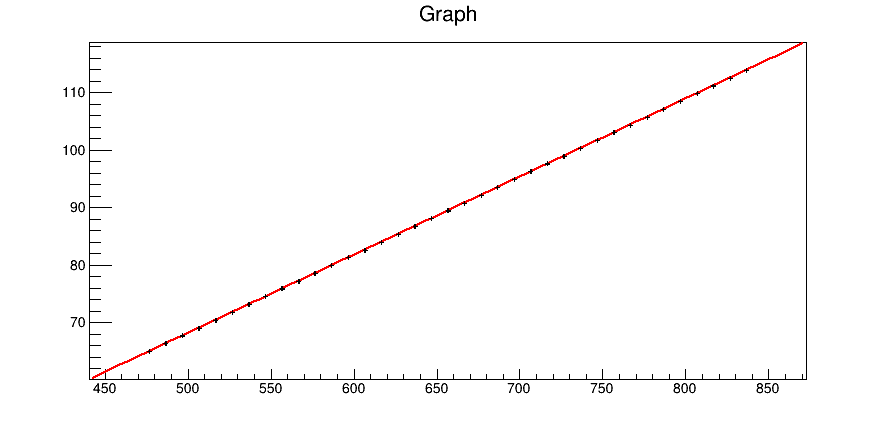

In [38]:
gr = makeGraph(vZ,vR,eZ,eR)
gr.Draw("AP")
gr.Fit(f_pol1)
tgG = VE(f_pol1.GetParameter(1),f_pol1.GetParError(1)**2)
th_gr = 1000.*math_ve.atan(tgG)
print("GRAPH mean" + str(th_gr) + " mrad.\t" + str(th_gr.prec()))
print("TRUE mean" + str(th_true) + " mrad.") 
print("   --> " +str(th_gr-th_true)+ "\n")
print("REC. mean" + str(th_reco) + " mrad.\t" + str(th_reco.prec()) + "\n") 
canv.Draw()